In [16]:
import matplotlib.pyplot as plt
import pandas as pd

from strategy import backtest
from tools import *

def read_data(path, password):
    _df = crp.read_encrypted(path=path, password=password)
    _df = _df.fillna(0)
    _df /= 100  # change to decimal
    
    _df = _df.apply(lambda x : np.where(x > 1, 0, x))
    _df = _df.apply(lambda x : np.where(x < -1, 0, x))
    
    _df['strat_4'] = 0
    _df['strat_5'] = 0
        
    return _df

path = './public_data/'

file_name = 'release_5979.crypt'  # example: release_3547.crypt
password = 'WlWszEj1WRNCfRzF' 
df = read_data(path=path + file_name, password=password)

new_file_name = 'release_5979.crypt'
new_password = 'WlWszEj1WRNCfRzF'

In [17]:
ranks = pd.DataFrame()
data = df[-78:].copy()
ranks['Sortino'] = sortino_ratio(data).sort_values(ascending=False)
ranks['Max Drawdown'] = max_drawdown(data).sort_values(ascending=True)
ranks

,Sortino,Max Drawdown
strat_19,16.737590,0.038711
strat_7,11.424594,0.061288
strat_48,10.697626,0.036382
strat_54,8.932305,0.053456
strat_29,8.569621,0.032927
strat_51,6.911081,0.035571
strat_41,6.791219,0.030136
strat_27,6.278709,0.043443
strat_32,5.449018,0.092308
strat_52,5.127372,0.031970


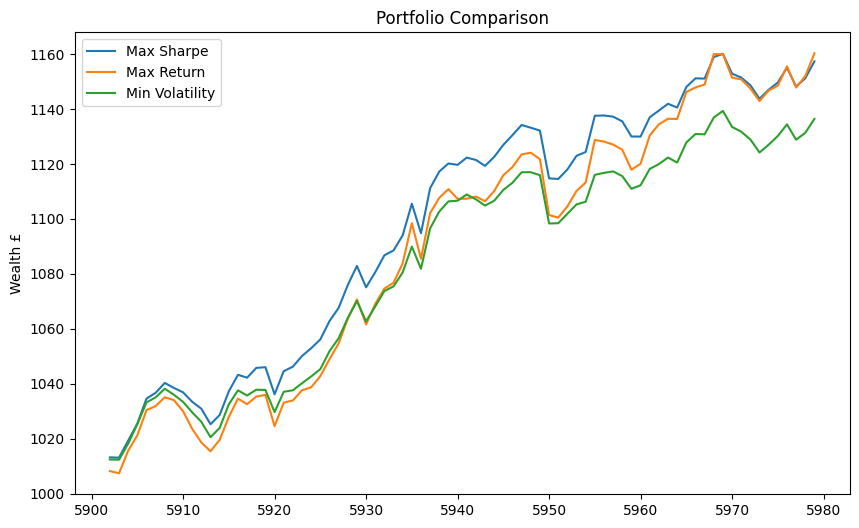

1.0
1.0


In [18]:
portfolio_weights = []
portfolio_returns = []
portfolio_risks = []
portfolio_sharpes = []

def compute_portfolio_return(_df, _weights):
    return (1 + np.sum(_weights * _df.mean())) ** 252 - 1

def compute_portfolio_risk(_df, _weights):  # portfolio variance formula
    return np.sqrt(_weights.T @ (_df.cov() * 252) @ _weights)

def compute_random_portfolio(_df, _iterations) -> None:
    ranks = sortino_ratio(_df).sort_values(ascending=False).index[:24] 
    ranks = [int(strat[6:]) for strat in ranks]
    no_of_stocks = _df.shape[1]
    
    rank_4 = ranks[:4] # top 4
    for i in range(_iterations):
        weights = np.zeros(no_of_stocks)
        for n in range(no_of_stocks):
            if n in rank_4 or n not in ranks:
                weights[n] = 0
            else:
                x = np.random.random()
                if x > 0.1:
                    x /= 2
                weights[n] = x + 0.001
                
        weights = weights.round(4)
        weights /= abs(weights).sum()
        weights *= 0.6
        
        for n in rank_4:
            weights[n] = 0.1
        
        portfolio_weights.append(weights)
        
        expected_return = compute_portfolio_return(_df, weights)
        portfolio_returns.append(expected_return)
        
        risk = compute_portfolio_risk(_df, weights)
        portfolio_risks.append(risk)
        
        sharpe = expected_return / risk
        portfolio_sharpes.append(sharpe)
    
data = df[-78:]

# run the simulations
compute_random_portfolio(data, 10_000)

# get the Max Sharpe Ratio, Max Return, Min Volatility
max_sharpe = max(portfolio_sharpes)
max_return = max(portfolio_returns)
min_risk = min(portfolio_risks)

# find the portfolio index for each
sharpe_idx = portfolio_sharpes.index(max_sharpe)
return_idx = portfolio_returns.index(max_return)
min_risk_idx = portfolio_risks.index(min_risk)

# find the portfolio weights for each
sharpe_w = portfolio_weights[sharpe_idx]
max_return_w = portfolio_weights[return_idx]
min_risk_w = portfolio_weights[min_risk_idx]

INITIAL_CASH = 1_000

def compute_wealth(_df, _weights):
    initial_values = (1 + _df.iloc[0]) * _weights * INITIAL_CASH
    cumulative_ret = np.cumprod(1 + _df)
    cumulative_wealths = cumulative_ret * initial_values
    
    return cumulative_wealths.sum(axis=1)


values = pd.DataFrame()
values['Max Sharpe'] = compute_wealth(data, sharpe_w)
values['Max Return'] = compute_wealth(data, max_return_w)
values['Min Volatility'] = compute_wealth(data, min_risk_w)

plt.figure(figsize=(10, 6))
plt.plot(values['Max Sharpe'], label='Max Sharpe')
plt.plot(values['Max Return'], label='Max Return')
plt.plot(values['Min Volatility'], label='Min Volatility')
plt.title('Portfolio Comparison')
plt.ylabel('Wealth £')
plt.legend()
plt.show()

# find the portfolio weights
results_weights = pd.DataFrame(index=data.columns)
results_weights['max sharpe ratio'] = sharpe_w
results_weights['max return'] = max_return_w
results_weights['min risk'] = min_risk_w 

clipped_weights = results_weights['max sharpe ratio']
print(sum(clipped_weights))

# clipped_weights
# more = sum(clipped_weights) - 1
# if more != 0:
#     stuff = results_weights['max sharpe ratio'].sort_values(ascending=False)
#     print(stuff)
#     idx = 0
#     if more > 0:
#         while more > 0:
#             if stuff[idx] < 0.1:
#                 more += stuff[idx] - 0.1
#                 stuff[idx] = 0.1
#             elif stuff[idx] > 0.1:
#                 if 0.1 - stuff[idx] > more: # can fill in whole gap with more
#                     stuff[idx] += more
#                     more = 0
#                 else:
#                     more -= (0.1 - stuff[idx])
#                     stuff[idx] = 0.1
#     else: # we are missing stuff
#         more *= -1
#         while more > 0:
#             if stuff[idx] < 0.1:
#                 more += stuff[idx] - 0.1
#                 stuff[idx] = 0.1
#             elif stuff[idx] > 0.1:
#                 if 0.1 - stuff[idx] > more: # can fill in whole gap with more
#                     stuff[idx] += more
#                     more = 0
#                 else:
#                     more -= (0.1 - stuff[idx])
#                     stuff[idx] = 0.1
# clipped_weights = results_weights['max sharpe ratio']
print(sum(clipped_weights))

In [19]:
pos_dict = clipped_weights.to_dict()
get_submission_dict(pos_dict)

{'strat_0': 0.0,
 'strat_1': 0.0,
 'strat_2': 0.0,
 'strat_3': 0.02366961167043353,
 'strat_4': 0.0,
 'strat_5': 0.0,
 'strat_6': 0.03414834600369838,
 'strat_7': 0.1,
 'strat_8': 0.0,
 'strat_9': 0.0,
 'strat_10': 0.0,
 'strat_11': 0.0,
 'strat_12': 0.0,
 'strat_13': 0.0,
 'strat_14': 0.0,
 'strat_15': 0.0,
 'strat_16': 0.030844462708033694,
 'strat_17': 0.010873227861105403,
 'strat_18': 0.0,
 'strat_19': 0.1,
 'strat_20': 0.008580234230532155,
 'strat_21': 0.003118964454489418,
 'strat_22': 0.0,
 'strat_23': 0.0,
 'strat_24': 0.0,
 'strat_25': 0.012636120813642899,
 'strat_26': 0.007335114033285391,
 'strat_27': 0.05817546743373741,
 'strat_28': 0.06033285391411547,
 'strat_29': 0.05741113622354633,
 'strat_30': 0.0009492500513663448,
 'strat_31': 0.0,
 'strat_32': 0.04900349291144442,
 'strat_33': 0.0,
 'strat_34': 0.011921101294431887,
 'strat_35': 0.0,
 'strat_36': 0.0,
 'strat_37': 0.0,
 'strat_38': 0.05023628518594616,
 'strat_39': 0.0328292582699815,
 'strat_40': 0.0,
 'strat_

In [20]:
df1 = read_data(path + new_file_name, new_password)
pnls = pnl(df1[-78:], clipped_weights)

In [21]:
from strategy import *
history = []
backtest(history, get_submission_dict(pos_dict), new_file_name, new_password)

0.14950450449764152


In [22]:
history

[0.006438735054332824,
 -0.0001433507586844307,
 0.006129887564400369,
 0.005949730896473358,
 0.008782172531813445,
 0.002001199592350004,
 0.0034285268477998888,
 -0.0016238257120693635,
 -0.001556236160964815,
 -0.0034403077299214858,
 -0.0023050991071954826,
 -0.005257864292715701,
 0.003189149802285964,
 0.008208899384095095,
 0.005725232710800107,
 -0.0013804745720172212,
 0.0031643385368301364,
 0.0003355077851258664,
 -0.009080247110566013,
 0.008201683763486501,
 0.0015011105830844637,
 0.003857413051259691,
 0.0026586755459312283,
 0.003070682231284811,
 0.0060778770023044455,
 0.004483908221384186,
 0.00757681611467208,
 0.0061621823681768904,
 -0.006821398257984832,
 0.005163556512576719,
 0.005256503552256424,
 0.0015700844556839205,
 0.00512692061070635,
 0.010445324202313502,
 -0.009754984295699277,
 0.014708681202233002,
 0.005816105134579452,
 0.002738851420475506,
 -0.0007055153929353279,
 0.0023802866166350435,
 -0.00029411543294675506,
 -0.001964697386446696,
 0.003

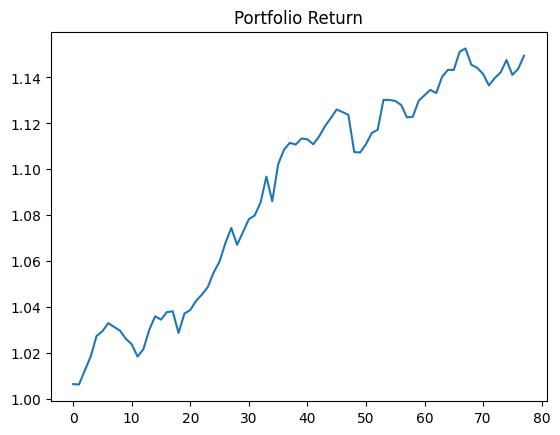

Annual Return:  0.5731533035994274
Annual Volatility:  0.07670306367402006
Cumulative Return:  0.14950450449764152


In [23]:
plt.plot(np.cumprod(1 + pnls))
plt.title('Portfolio Return')
plt.show()

sharpe = sharpe_ratio(pnls)
print('Annual Return: ', annual_return(pnls))
print('Annual Volatility: ', annual_risk(pnls))
print('Cumulative Return: ', get_value(pnls)[-1] - 1)

Sharpe:  0.294337167565966
Cumulative Return:  0.003528467006129077


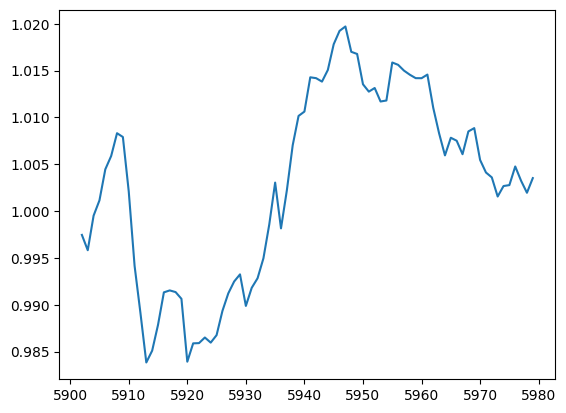

In [24]:
plt.plot(np.cumprod(1 + df1[-78:].mean(axis=1)))
print('Sharpe: ', sharpe_ratio(df1[-78:].mean(axis=1)))
print('Cumulative Return: ', get_value(df1[-78:].mean(axis=1)).iloc[-1] - 1)